# XGBoost
e**X**treme **G**radient **B**oosting

---

<a id='evolution_boosting_bagging'></a>
![evolution_boosting_bagging](./images/evolution_boosting_bagging.png) 

A response to:
- increasingly noisy datasets
- increasing need to shorten training times for application to business use cases
- the availability of more computational resourses for broader hyperparameter tuning


**XGBoost was developed to increase speed and performance, while introducing regularization parameters to reduce overfitting.**

## Boosting
>"Influencing the next iteration of your model"

---

### The concept
1. In its most basic form its ensemble method that takes a **weak base learner** and tries to make it a **strong learner** by retraining it on the misclassified samples. **It ultimately aims to reduce bias**
2. Rationale/theory: to combine **many weak learners into a single strong learner.**
3. The base model fitting is **iterative** (not parallel like Bagging, Random Forest, ExtraTrees)
4. Most basic version (Adaptive Boosting) is where **Weights are assigned to observations to indicate their "importance:"** Samples with higher weights are given higher influence on the total error of the subsequent model, prioritizing those observations.
4. **Weights change at each iteration with the goal of correcting the errors/misclassifications of the previous iteration**: 
The use of iterative fitting is ultimately to explain error/misclassifications that are unexplained by the previous base models and reduces bias without increasing variance.
The first base estimator is fit with uniform weights on the observations.
5. **Final prediction is typically constructed by a weighted vote**: Weights for each base model depend on their training errors or misclassification rates.

6. In the most basic for of boosting, deep/full decision trees are not utilised, **it uses shallow/high-bias base estimators.**

7. The aim is for each weak learner to have a low variance and a high bias

<a id='boost_vs_bagg'></a>
![boostvsbag](./images/boosting_vs_bagging.png) 

### The Math
Illustrated by Adaptive boosting

AdaBoost is the original boosting algorithm. Predictions from AdaBoost follow this formula:


$$ {\rm AdaBoost}(X) = {\rm sign}\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

Where:

- ${\rm AdaBoost}(X)$ are the classification predictions for $y$ using the predictor matrix $X$

- $T$ is the number of "weak learners"

- $\alpha_t$ is the contribution weight for weak learner $t$

- $h_t(X)$ is the prediction of weak learner $t$

- $y$ is binary **with values of minus one and one**

The core principle of AdaBoost is to **fit a sequence of weak learners** (i.e., models that are only slightly better than random guessing, such as a single-split tree) **on repeatedly modified versions of the data**. After each fit, the importance weights on each observation need to be updated. 

The predictions are then combined through a weighted majority vote (or sum) to produce the final prediction. AdaBoost, like all boosting ensemble methods, focuses the next model's fit on the misclassifications/weaknesses of the prior models.

All $N$ training examples start with equal importance weighting 

$$w_0=\frac{1}{N}$$ 

At each iteration step $t$ the weights $w_t$ will be adjusted for each observation.

When we finish training the classifier $h_t$ at each iteration step taking the weights $w_t$ into account we evaluate which predictions have been made correctly and where errors occurred. 

Then we update the importance weighting of the classifier itself, represented by $\alpha_t$:

$$ \alpha_t = \log \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$$

where $\epsilon_t$ is the weighted misclassification rate for the current classifier:

$$ \epsilon_t = \frac{\sum_{i=1}^N w_{i,t} {I}(y_i\neq h_t(X_i))}{\sum_{i=1}^N w_{i,t}} $$

Here the indicator function ${I}(y_i\neq h_t(X_i))$ returns one for incorrect predictions and zero for correct predictions.

As iterations continue, **examples that are difficult to predict receive ever-increasing influence**. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

### Visualization

![boostvsbag](./images/adaboost-viz.png)

### The Adaboost algorithm

- initialize weights $w_0=1/N$ ($N$ is the number of observations)
- for t=1:T do
    - Fit a classifier $h_t(X)$ to the training set $X$ using weights $w$
    - Compute the error rate 
$\epsilon_t = \frac{\sum_{i=1}^N w_{i,t} {I}(y_i\neq h_t(X_i))}{\sum_{i=1}^N w_{i,t}} $
    - Compute $ \alpha_t = \log \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$
    - Set $ w_{t+1,i} = w_{t,i} e^{\alpha_t  {I}(y_i\neq h_t(X_i))} $
- Return $ {\rm AdaBoost}(X) = {\rm sign}\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $

### Example code

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


"""
Note this is the Stagewise Additive Modeling using a Multiclass Exponential loss function (SAMME) approach
"""

class ada_boost_class:
    
    def __init__(self, base_estimator=DecisionTreeClassifier(max_depth=1, random_state=99), n_estimators=20):
        """
        arguments: base_estimator, number of estimators
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
    
    def _calculate_error_rate(self,w, miss):
        """
        arguments: weights and mask for misclassified data points (miss)
        returns: error rate
        """ 
        return np.dot(w, miss) / w.sum()
    
    def _calculate_alpha(self, error_rate):
        """
        calculates the alpha value at current iteration step
        argument: error rate
        returns: alpha_m
        """
        return np.log((1. - error_rate) / error_rate)
    
    def _indicator_function(self, y, pred):
        """
        arguments: target variable and predicted values
        returns: 1 if disagreement, 0 else
        """
        return (pred != y)*1
    
    def _binary_converter(self, y):
        """
        Convert binary class labels to 1/-1 (one of the labels must be codes as 1)
        """
        return np.array([x if x == 1 else -1 for x in y])
    
    def _update_importance_weights(self, w, miss, alpha_t):
        """
        arguments: current weights, mask for misclassified observations, alpha_m
        returns: w, the updated weight
        """
        w = np.multiply(w, np.exp([float(x) * alpha_t for x in miss]))
        return w

    def _update_predictions(self, pred, pred_t, alpha_t):
        """
        update the predictions with the ones of the current model
        arguments: previous aggregated predictions (pred), 
                   predictions at current iteration,
                   alpha_m
        returns: updated predictions
        """
        pred = [sum(p) for p in zip(pred, [m * alpha_t for m in pred_t])]
        return pred
    
    def _get_score(self, y, pred, score=accuracy_score):
        """
        arguments: target values and predicted values
        returns: score
        """
        return score(y, pred)
    
    def _model_predictions(self, X_train, y_train, X_test, y_test, sample_weight=None):
        """
        arguments: model, training and test sets, sample weights
        body: fit the model and make predicitions
        returns: training predictions and test predictions
        """
        self.base_estimator.fit(X_train, y_train, sample_weight=sample_weight)
        pred_train = self.base_estimator.predict(X_train)
        pred_test = self.base_estimator.predict(X_test)
        return pred_train, pred_test
    
    def _generic_model(self, X_train, y_train, X_test, y_test):
        """
        arguments: train and test sets for X, y and a model
        fits the model on the training data and obtains train/test predictions
        returns: train/test scores
        """
        pred_train, pred_test = self._model_predictions(
                X_train, y_train, X_test, y_test)
        
        return self._get_score(y_train, pred_train), \
            self._get_score(y_test, pred_test)
    
    
    def predict(self, X_train, y_train, X_test, y_test,array=False):
        """
        arguments: training/test set predictors and labels
        returns: predicted labels after iteration over n_estimators
        """
        
        # measure size of train/test sets
        n_train, n_test = len(X_train), len(X_test)
        # Initialize weights
        w = np.ones(n_train) / n_train
        # Initialize train/test predictions
        pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
        # convert labels to 1/-1
        ytilde_train = self._binary_converter(y_train)
        ytilde_test = self._binary_converter(y_test)
        
        for i in range(self.n_estimators):
            # Fit a classifier with the current weights
            pred_train_i, pred_test_i = self._model_predictions(
                X_train, y_train, X_test, y_test, sample_weight=w)
            # convert predicted labels to 1/-1
            pred_train_i = self._binary_converter(pred_train_i)
            pred_test_i = self._binary_converter(pred_test_i)
            # Indicator function
            miss = self._indicator_function(pred_train_i, ytilde_train)
            # Error
            err_m = self._calculate_error_rate(w, miss)
            # Alpha
            alpha_m = self._calculate_alpha(err_m)
            # update weights
            w = self._update_importance_weights(w, miss, alpha_m)
            # Add to prediction
            pred_train = self._update_predictions(pred_train, pred_train_i, alpha_m)
            pred_test = self._update_predictions(pred_test, pred_test_i, alpha_m)

        # get the sign of train/test predictions
        pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
        
        return pred_train, pred_test
        
    def score(self, X_train, y_train, X_test, y_test):
    
        ytilde_train = self._binary_converter(y_train)
        ytilde_test = self._binary_converter(y_test)
        pred_train, pred_test = self.predict(
            X_train, y_train, X_test, y_test)
        
        # Return train/test scores
        return self._get_score(ytilde_train, pred_train), \
            self._get_score(ytilde_test, pred_test)

### Comparing Custom Adaboost on Breast Cancer Dataset

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
df = pd.DataFrame(columns=data.feature_names, data=X)
df['cancer'] = y

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

#### Custom Adaptive Boosting

In [3]:
my_custom_adaboost = ada_boost_class()
my_custom_adaboost.score(X_train, y_train,X_test, y_test)

(0.9934065934065934, 0.9210526315789473)

#### Sci-kit Learn Adaptive Boosting

In [4]:
sklearn_adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1,random_state=99),
    n_estimators=20,
    algorithm='SAMME')

In [5]:
sklearn_adaboost.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=99),
                   n_estimators=20)

In [6]:
sklearn_adaboost.score(X_train, y_train), sklearn_adaboost.score(X_test, y_test)

(0.9934065934065934, 0.9210526315789473)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def fit_model(X_train, y_train, X_test, y_test,iterations=20):
    
    er_train, er_test = [], []  

    x_range = range(1, iterations+1)
    for i in x_range:
        ada= ada_boost_class(n_estimators=i)
        er_i = ada.score(X_train,y_train,X_test, y_test)
        er_train.append(er_i[0])
        er_test.append(er_i[1])

    return er_train, er_test


def plot_scores(y_1, y_2, y_3, y_4, iterations):
    
    x_range = range(1, iterations+1)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(x_range, y_1, ls='--', lw=2, label='custom adaboost training score')
    ax.plot(x_range, y_2, ls='--', lw=2, label='custom adaboost testing score')
    ax.plot(x_range, y_3, alpha=0.5, lw=2, label='scikit-learn adaboost training score')
    ax.plot(x_range, y_4, alpha=0.5, lw=2, label='scikit-learn adaboost testing score')
    ax.set_xlabel('iterations')
    ax.set_ylabel('accuracy')
    ax.legend()
    plt.title("Comparison of Custom Adaptive Boosting to Sci-Kit Learn Adaptive Boosting")
    return fig, ax

Does Custom AdaBoost model and sklearn AdaBoost agree on the training set? True
DDoes Custom AdaBoost model and sklearn AdaBoost agree on the test set? True


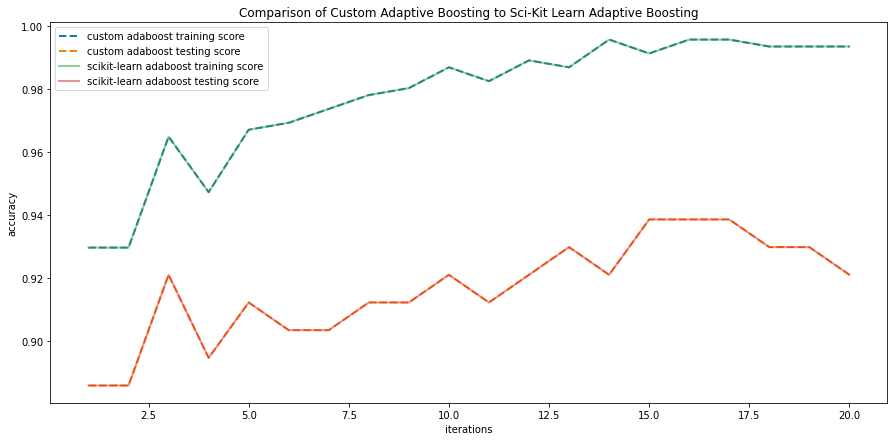

In [8]:
er_train, er_test = fit_model(X_train, y_train,X_test, y_test,20)

y_1 = np.array(er_train) 
y_2 = np.array(er_test)
y_3 = np.array(list(sklearn_adaboost.staged_score(X_train, y_train)))
y_4 = np.array(list(sklearn_adaboost.staged_score(X_test, y_test)))

print('Does Custom AdaBoost model and sklearn AdaBoost agree on the training set?', np.allclose(y_1, y_3))
print('DDoes Custom AdaBoost model and sklearn AdaBoost agree on the test set?', np.allclose(y_2, y_4))

fig, ax = plot_scores(y_1, y_2, y_3, y_4, 20)

- AdaBoost can be considered a subcase of Gradient Boosting for a particular type of loss function (exponential loss).

## Gradient
Gradient boosting are a generalization of boosting to arbitrary, differentiable loss functions. The intuition behind this mechanism is to:

---

1. Fit a model $F_0$ to the data.
2. Look at the difference between our observed $y$ and our model $F_0$. (The $y_i - F_0(x_i)$ can be thought of as residuals!)
3. Fit a second model, $F_1$, to (roughly) the residuals $y_i - F_0(x_i)$.
4. Aggregate your model $F_0$ and $F_1$. Residuals can be interpreted as negative gradients. Using a negative gradient the gradient descent algorithm can be applied to optimize the loss and generalize this to many loss functions (Least Squares, Least Absolute Deviation, M-Regression, Exponential Loss)

1. $F_0(x) = arg min_ρ\sum_{i=1}^NL(y_i,ρ)$
2. For $m = 1$ to $M$ do:
3. $\tilde{y}_i = −[\frac{\partial{L}(y_i,F(x_i))}{\partial{F}(x_i)}]_{F(x)=F_{m−1}(x)},i = 1,N$ - Steepest Descent
4. $a_m = arg min_{a,\beta}\sum_{i=1}^N[\tilde{y}_i−\beta h(x_i;a)]^2$
5. $\rho_m = arg min_\rho\sum_{i=1}^N L(y_i,F_{m−1}(x_i) + \rho h(x_i;a_m))$
6. $F_m(x) = F_{m−1}(x) + \rho_mh(x;a_m)$

[Greedy Function Approximation: A Gradient Boosting Machine](https://projecteuclid.org/journals/annals-of-statistics/volume-29/issue-5/Greedy-function-approximation-A-gradient-boostingmachine/10.1214/aos/1013203451.full?tab=ArticleFirstPage)


[A Gentle Introduction to Gradient Boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf)

[Gradient boosting machines, a tutorial](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)

[A Local Example](./GBM_example.xlsx)

In [153]:
age_data_raw = [
    [0,1,0,1,14],
    [0,1,0,0,15],
    [0,1,1,0,16],
    [1,1,0,1,26],
    [0,1,0,1,36],
    [1,0,0,0,50],
    [1,1,1,1,69],
    [1,0,1,0,72],
    [1,0,1,1,73]
]

age_data = pd.DataFrame(data=age_data_raw,columns=["LikesJogging","GotoGym","SmokesCigars","DrivesSportsCar","Age"])
age_data

,LikesJogging,GotoGym,SmokesCigars,DrivesSportsCar,Age
0,0,1,0,1,14
1,0,1,0,0,15
2,0,1,1,0,16
3,1,1,0,1,26
4,0,1,0,1,36
5,1,0,0,0,50
6,1,1,1,1,69
7,1,0,1,0,72
8,1,0,1,1,73


In [205]:
def calculate_loss(resid, loss_function=None):
    
    if loss_function =='Absolute':
        return abs(resid)
    elif loss_function =='Huber':
        if abs(resid) < 1:
            return (abs(resid)**2)/2
        else:
            return abs(resid)-0.5
    else:
        return resid**2

    
def calculate_mean(df, estimator_column, predictor_column):
    mean_true = np.mean(list(filter(lambda x: x!= -9999, np.where(df[predictor_column]==1,df[estimator_column],-9999))))
    mean_false = np.mean(list(filter(lambda x: x!= -9999, np.where(df[predictor_column]==0,df[estimator_column],-9999)))) 
    return df[[predictor_column,estimator_column]]\
.apply(lambda x: 
       mean_true
       if x[predictor_column]==1 
       else 
       mean_false,axis=1)


def calculate_residuals(df, estimator_column, mean_column):
    return df[estimator_column] - df[mean_column]


loss_function = "Square Loss"

age_data['resid_0'] = age_data['Age']-age_data['Age'].mean()
age_data['loss_0'] = age_data['resid_0'].apply(calculate_loss,args=[loss_function])

# Stage 1 - LikesJogging
age_data['mean_1'] = calculate_mean(age_data, 'Age','LikesJogging')
age_data['resid_1'] = calculate_residuals(age_data, 'Age','mean_1')
age_data['loss_1'] = age_data['resid_1'].apply(calculate_loss,args=[loss_function])

# Stage 2 - GotoGym
age_data['mean_2'] = calculate_mean(age_data, 'resid_1','GotoGym')
age_data['resid_2'] = calculate_residuals(age_data, 'resid_1','mean_2')
age_data['loss_2'] = age_data['resid_2'].apply(calculate_loss,args=[loss_function])

# Stage 3 - SmokesCigars
age_data['mean_3'] = calculate_mean(age_data, 'resid_2','SmokesCigars')
age_data['resid_3'] = calculate_residuals(age_data, 'resid_2','mean_3')
age_data['loss_3'] = age_data['resid_3'].apply(calculate_loss,args=[loss_function])

# Stage 4 - DrivesSportsCar
age_data['mean_4'] = calculate_mean(age_data, 'resid_3','DrivesSportsCar')
age_data['resid_4'] = calculate_residuals(age_data, 'resid_3','mean_4')
age_data['loss_4'] = age_data['resid_4'].apply(calculate_loss,args=[loss_function])

In [206]:
age_data

,LikesJogging,GotoGym,SmokesCigars,DrivesSportsCar,Age,resid_0,loss_0,mean_1,resid_1,loss_1,mean_2,resid_2,loss_2,mean_3,resid_3,loss_3,mean_4,resid_4,loss_4
0,0,1,0,1,14,-27.222222,741.049383,20.25,-6.25,39.0625,-3.5,-2.75,7.5625,-5.7500,3.0000,9.000000,2.67500,0.32500,0.105625
1,0,1,0,0,15,-26.222222,687.604938,20.25,-5.25,27.5625,-3.5,-1.75,3.0625,-5.7500,4.0000,16.000000,-3.34375,7.34375,53.930664
2,0,1,1,0,16,-25.222222,636.160494,20.25,-4.25,18.0625,-3.5,-0.75,0.5625,7.1875,-7.9375,63.003906,-3.34375,-4.59375,21.102539
3,1,1,0,1,26,-15.222222,231.716049,58.00,-32.00,1024.0000,-3.5,-28.50,812.2500,-5.7500,-22.7500,517.562500,2.67500,-25.42500,646.430625
4,0,1,0,1,36,-5.222222,27.271605,20.25,15.75,248.0625,-3.5,19.25,370.5625,-5.7500,25.0000,625.000000,2.67500,22.32500,498.405625
5,1,0,0,0,50,8.777778,77.049383,58.00,-8.00,64.0000,7.0,-15.00,225.0000,-5.7500,-9.2500,85.562500,-3.34375,-5.90625,34.883789
6,1,1,1,1,69,27.777778,771.604938,58.00,11.00,121.0000,-3.5,14.50,210.2500,7.1875,7.3125,53.472656,2.67500,4.63750,21.506406
7,1,0,1,0,72,30.777778,947.271605,58.00,14.00,196.0000,7.0,7.00,49.0000,7.1875,-0.1875,0.035156,-3.34375,3.15625,9.961914
8,1,0,1,1,73,31.777778,1009.827160,58.00,15.00,225.0000,7.0,8.00,64.0000,7.1875,0.8125,0.660156,2.67500,-1.86250,3.468906


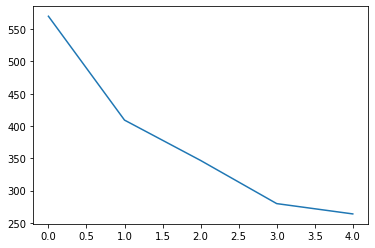

In [207]:
def plot_loss_function(df):
    
    loss_data = [df['loss_0'].mean()]
    
    pattern = {'loss_1':'LikesJogging',
              'loss_2':'GotoGym',
              'loss_3':'SmokesCigars',
              'loss_4':'DrivesSportsCar'}
    
    for loss_column,predictor_column in pattern.items():
        mean_true = np.mean(list(filter(lambda x: x!= -9999, np.where(df[predictor_column]==1,df[loss_column],-9999))))
        mean_false = np.mean(list(filter(lambda x: x!= -9999, np.where(df[predictor_column]==0,df[loss_column],-9999))))
        loss_data.append(mean_true+mean_false)
        
    pd.Series(loss_data).plot()
        
plot_loss_function(age_data)

In [220]:
age_data[['LikesJogging','mean_1']].drop_duplicates().reset_index(drop='index').set_index('LikesJogging').to_dict()['mean_1']

{0: 20.25, 1: 58.0}

In [242]:
def predict_age(df, array):
    
    store_prediction = []
    
    for n,(i,predictor) in enumerate(zip(array,['LikesJogging','GotoGym','SmokesCigars','DrivesSportsCar'])):
        store_prediction.append(df[[predictor,f'mean_{n+1}']].drop_duplicates().reset_index(drop='index').set_index(predictor).to_dict()[f'mean_{n+1}'][i])
    #second = df[['GotoGym','mean_2']].drop_duplicates().reset_index(drop='index').set_index('GotoGym').to_dict()['mean_2']
    return sum(store_prediction)

In [243]:
predict_age(age_data,[0,0,0,0])

18.15625

## eXtreme
Extreme regularisation & computation

---

In [12]:
import xgboost

In [13]:
xgboost.XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

---
### Boosting Parameters

Controls the performance of the selected booster

- **learning_rate** - Controls the maximum number of iterations, the lower values will generate the slower computation.

- <span style="color:red">**gamma**</span> - Controls the regularization. 0 means (no regularization). The higher gamma is the higher regularization, regularization means penalizing large coefficients that don’t improve the model’s performance.

- **reg_alpha** - L1 regularization term on weights (xgb's alpha)
- **reg_lambda** - L2 regularization term on weights (xgb's lambda)

- **n_estimators** - Controls the maximum number of iterations.

- **max_depth** - Controls Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

- **min_child_weight** - If the leaf node has a minimum sum of instance weight lower than min_child_weight in the tree partition step than the process of splitting the tree will stop growing.

- **subsample**- Controls the number of ratio observations to a tree. A value of 0.5 means that XGboost would randomly sample half of the training data prior to growing trees and this will prevent overfitting. subsample occurs once in every boosting iteration.

- <span style="color:red">**colsample_bytree**</span>  - Controls the subsample ratio of columns when constructing each tree.Similar to random feature selection in Random Forests

- <span style="color:red">**num_parallel_tree**</span> - Boosting a Random Forest estimator



### Learning Task Parameters
Sets and evaluates the learning process of booster from the given data.

- **objective** - `reg:squarederror` for regression with squared loss, `binary:logistic` for binary classification
- **eval_metric** - evaluation metrics for validaton data. (e.g. RMSE, error)

### General & Computational Parameters

Controls the booster type in the model which eventually drives overall functioning

- **booster**

> `gbtree` - For classification problems. In `gbtree` a tree is grown one after other and attempts to reduce misclassification reate in subsequent iterations. The next tree is built by giving a higher weight to misclassified points by the previous tree.

> `gblinear` or `gbtree` - For regression problems. In `gblinear`, it builds a generalized linear model and optimizes it using regularization and gradient descent. The next model will built on residuals generated by previous iterations.

- **n_jobs** - To enable parallel computing. -1 is the maximum number of cores available

- **verbosity** - Verbosity to display warning messages.1 (warning), 0 for silent, 2 for info, and 3 for debug.